
# Model Comparison & Visualization

This notebook loads the models made (e.g., DistilBERT, BERT-base, RoBERTa-base), evaluates them on the validation/test splits, and generates the following graphics:
- Confusion matrix (test) for each model
- Per-class precision/recall/F1 bars (test) for each model
- Comparison bar charts (macro-F1 / accuracy across models)



## libraries

In [1]:
# imports
import os, json, random
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math

## Setup

In [2]:
# Connecting to google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 3) loading data and models
BASE = "/content/drive/MyDrive/Project_NLP"

PARQUET_FULL   = f"{BASE}/video_games_preprocessed.parquet"
PREPROCESS_CFG = f"{BASE}/preprocess_config.json"
BEST_MODEL_rb  = f"{BASE}/models/rb_sample_e3_lr2e-5_wNeutral1p7_len192"
MODEL_dbu      = f"{BASE}/models/dbu_sample_e3_lr1e-5_wNeutral1p3"
MODEL_bbu      = f"{BASE}/models/bbu_sample_e3_lr1e-5_wNeutral1p3"

for name, p in [
    ("PARQUET_FULL", PARQUET_FULL),
    ("PREPROCESS_CFG", PREPROCESS_CFG),
    ("BEST_MODEL_rb", BEST_MODEL_rb),
    ("MODEL_dbu", MODEL_dbu),
    ("MODEL_bbu", MODEL_bbu),
]:
    print(f"{name:14} {'ok' if os.path.exists(p) else 'MISSING':8} -> {p}")

PARQUET_FULL   ok       -> /content/drive/MyDrive/Project_NLP/video_games_preprocessed.parquet
PREPROCESS_CFG ok       -> /content/drive/MyDrive/Project_NLP/preprocess_config.json
BEST_MODEL_rb  ok       -> /content/drive/MyDrive/Project_NLP/models/rb_sample_e3_lr2e-5_wNeutral1p7_len192
MODEL_dbu      ok       -> /content/drive/MyDrive/Project_NLP/models/dbu_sample_e3_lr1e-5_wNeutral1p3
MODEL_bbu      ok       -> /content/drive/MyDrive/Project_NLP/models/bbu_sample_e3_lr1e-5_wNeutral1p3


In [4]:
with open(PREPROCESS_CFG, "r") as f:
    cfg = json.load(f)
label2id = cfg.get("label2id", {"negative":0, "neutral":1, "positive":2})
id2label = {v:k for k,v in label2id.items()}
text_col  = cfg.get("text_col", "reviewText")
label_col = cfg.get("label_col", "sentiment")
print("label2id:", label2id, "| text_col:", text_col, "| label_col:", label_col)

label2id: {'negative': 0, 'neutral': 1, 'positive': 2} | text_col: clean_text | label_col: sentiment


In [5]:
# Load the parquet
df = pd.read_parquet(PARQUET_FULL)

# Ensure labels are integers (map if they’re still strings)
if not np.issubdtype(df[label_col].dtype, np.integer):
    df[label_col] = df[label_col].map(label2id).astype("int64")

# Split 70/15/15 stratified, with the same random_state=42
train_df, tmp_df = train_test_split(df, test_size=0.30, stratify=df[label_col], random_state=42)
val_df,   test_df = train_test_split(tmp_df, test_size=0.50, stratify=tmp_df[label_col], random_state=42)

print("train:", train_df.shape, "val:", val_df.shape, "test:", test_df.shape)
print("class counts (test):", test_df[label_col].value_counts().sort_index().to_dict())


train: (3237230, 14) val: (693692, 14) test: (693693, 14)
class counts (test): {0: 125910, 1: 51013, 2: 516770}


## Making definitions that we need for the evaluations

In [6]:
# definitions needed
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


def build_test_ds(df_test, tokenizer, max_length):
    ds = Dataset.from_pandas(
        df_test[[text_col, label_col]].rename(columns={text_col: "text", label_col: "labels"})
    )
    def tok(b):
        return tokenizer(b["text"], truncation=True, max_length=max_length)
    # progress bar with a description
    ds_tok = ds.map(tok, batched=True, remove_columns=["text"],
                    desc=f"Tokenizing test (max_len={max_length})")
    ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    collator = DataCollatorWithPadding(tokenizer=tokenizer)
    return ds_tok, collator

# --- Inference with a visible batch progress bar ---
def predict_split(model, dset, collator, bs=32, show_progress=True):
    preds, labels = [], []
    loader = torch.utils.data.DataLoader(dset, batch_size=bs, shuffle=False, collate_fn=collator)
    iterable = loader
    if show_progress:
        total_batches = math.ceil(len(dset) / bs)
        iterable = tqdm(loader, total=total_batches, desc="Inference", leave=False)
    for batch in iterable:
        labels.append(batch["labels"].numpy())
        batch = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        with torch.no_grad():
            logits = model(**batch).logits.detach().cpu().numpy()
        preds.append(logits)
    return np.concatenate(preds), np.concatenate(labels)

def plot_cm(cm, class_names, title):
    fig = plt.figure(figsize=(4.8,4.8))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(range(len(class_names)), class_names)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout(); plt.show()

def plot_prf(y_true, y_pred, class_names, title):
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(len(class_names)), zero_division=0)
    x = np.arange(len(class_names)); w = 0.25
    fig = plt.figure(figsize=(6.3,4))
    plt.bar(x - w, p, width=w, label="Precision")
    plt.bar(x,     r, width=w, label="Recall")
    plt.bar(x + w, f1, width=w, label="F1")
    plt.xticks(x, class_names); plt.ylim(0,1)
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

Device: cuda


## Evaluating models

Using stratified TEST sample: 100,000 rows

=== Evaluating TEST only: RoBERTa (192, LR=2e-5, w=1.7) ===


Tokenizing test (max_len=192):   0%|          | 0/100000 [00:00<?, ? examples/s]

Inference:   0%|          | 0/782 [00:00<?, ?it/s]

{'test_acc': 0.8745, 'test_macro_f1': 0.7344125944035139}
              precision    recall  f1-score   support

    negative      0.835     0.821     0.828     18151
     neutral      0.352     0.557     0.431      7354
    positive      0.971     0.919     0.944     74495

    accuracy                          0.875    100000
   macro avg      0.719     0.766     0.734    100000
weighted avg      0.901     0.875     0.885    100000



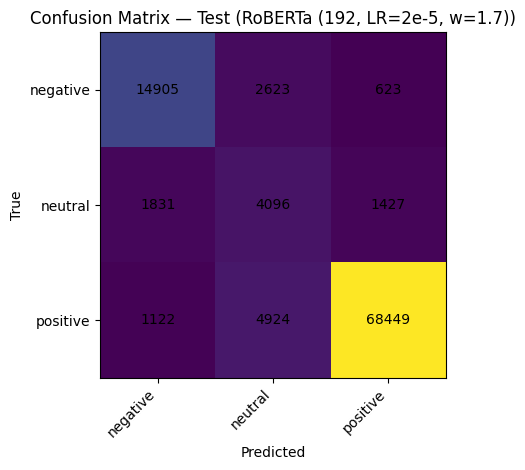

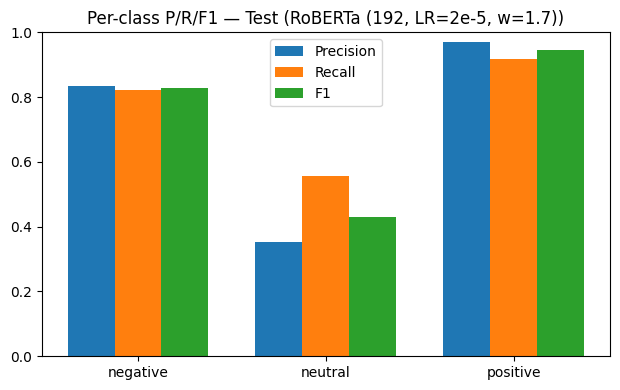


=== Evaluating TEST only: BERT-base ===


Tokenizing test (max_len=256):   0%|          | 0/100000 [00:00<?, ? examples/s]

Inference:   0%|          | 0/782 [00:00<?, ?it/s]

{'test_acc': 0.85844, 'test_macro_f1': 0.7132059276910906}
              precision    recall  f1-score   support

    negative      0.812     0.809     0.811     18151
     neutral      0.313     0.532     0.395      7354
    positive      0.969     0.903     0.934     74495

    accuracy                          0.858    100000
   macro avg      0.698     0.748     0.713    100000
weighted avg      0.892     0.858     0.872    100000



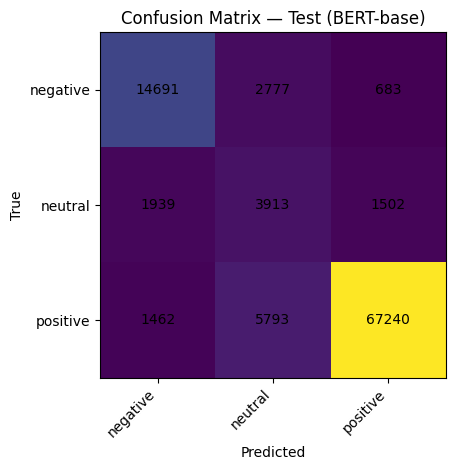

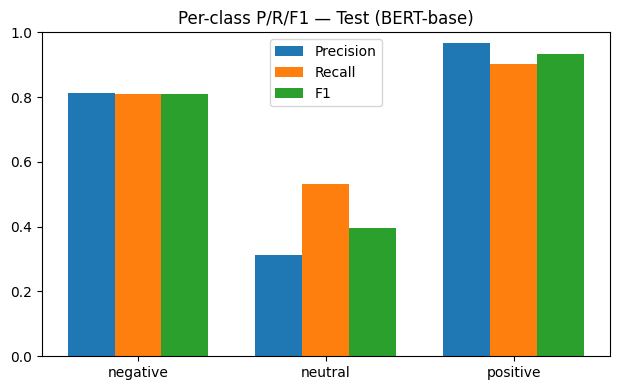


=== Evaluating TEST only: DistilBERT ===


Tokenizing test (max_len=256):   0%|          | 0/100000 [00:00<?, ? examples/s]

Inference:   0%|          | 0/782 [00:00<?, ?it/s]

{'test_acc': 0.84487, 'test_macro_f1': 0.7005431938611778}
              precision    recall  f1-score   support

    negative      0.792     0.804     0.798     18151
     neutral      0.291     0.538     0.378      7354
    positive      0.970     0.885     0.925     74495

    accuracy                          0.845    100000
   macro avg      0.684     0.742     0.701    100000
weighted avg      0.888     0.845     0.862    100000



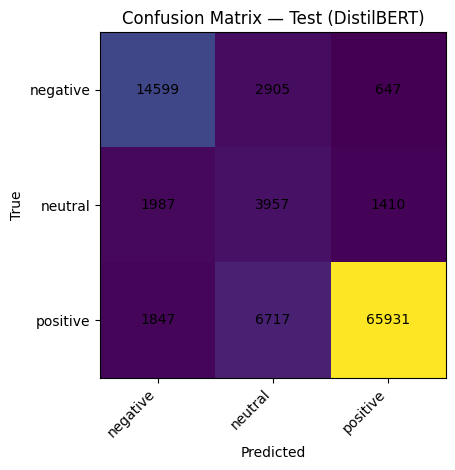

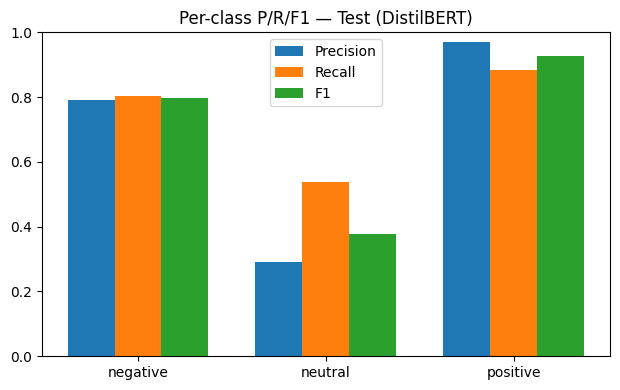

,model,macro_f1,accuracy
0,"RoBERTa (192, LR=2e-5, w=1.7)",0.734413,0.87450
1,BERT-base,0.713206,0.85844
2,DistilBERT,0.700543,0.84487


In [7]:
# Models to evaluate (name, path, max_length)
MODELS = [
    ("RoBERTa (192, LR=2e-5, w=1.7)", BEST_MODEL_rb, 192),
    ("BERT-base", MODEL_bbu, 256),
    ("DistilBERT", MODEL_dbu, 256),
]

TEST_SAMPLE_N = 100_000      # set to None for full test; try 50_000–100_000 for quick runs

if TEST_SAMPLE_N is not None and TEST_SAMPLE_N < len(test_df):
    # stratified sample to preserve class mix
    _, test_df_eval = train_test_split(
        test_df,
        test_size=TEST_SAMPLE_N,
        stratify=test_df[label_col],
        random_state=42,
    )
    test_df_eval = test_df_eval.reset_index(drop=True)
    print(f"Using stratified TEST sample: {len(test_df_eval):,} rows")
else:
    test_df_eval = test_df
    print(f"Using FULL TEST: {len(test_df_eval):,} rows")

results = []
class_names = [id2label[i] for i in range(3)]
BATCH_SIZE = 128   # adjust to 32 if you hit OOM; try 128 if GPU allows

for name, save_dir, max_len in MODELS:
    print(f"\n=== Evaluating TEST only: {name} ===")
    tokenizer = AutoTokenizer.from_pretrained(save_dir, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(save_dir).to(device).eval()

    ds_test_tok, collator = build_test_ds(test_df_eval, tokenizer, max_length=max_len)

    # uses your existing predict_split(...) helper
    logits, y_true = predict_split(model, ds_test_tok, collator, bs=BATCH_SIZE)
    y_pred = logits.argmax(axis=1)

    acc = accuracy_score(y_true, y_pred)
    mf1 = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)[2]

    print({"test_acc": acc, "test_macro_f1": mf1})
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    plot_cm(cm, class_names, f"Confusion Matrix — Test ({name})")
    plot_prf(y_true, y_pred, class_names, f"Per-class P/R/F1 — Test ({name})")

    results.append((name, mf1, acc))

# summary table
df_results = pd.DataFrame(results, columns=["model", "macro_f1", "accuracy"]).sort_values("macro_f1", ascending=False)
df_results

## Model comparison

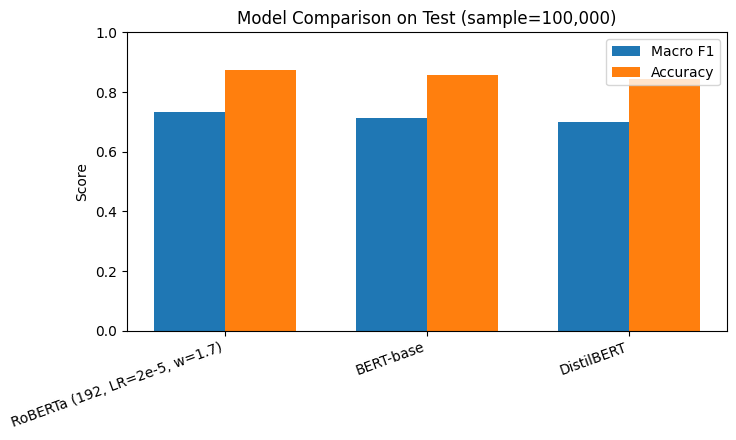

In [8]:
# Cross-model summary bar chart (Macro-F1 and Accuracy)
fig, ax = plt.subplots(figsize=(7.5, 4.5))

x = np.arange(len(df_results))
w = 0.35

ax.bar(x - w/2, df_results["macro_f1"], width=w, label="Macro F1")
ax.bar(x + w/2, df_results["accuracy"], width=w, label="Accuracy")

ax.set_xticks(x)
ax.set_xticklabels(df_results["model"], rotation=20, ha="right")
ax.set_ylim(0, 1.0)
ax.set_ylabel("Score")
ax.set_title("Model Comparison on Test" + ("" if TEST_SAMPLE_N is None else f" (sample={TEST_SAMPLE_N:,})"))
ax.legend()
plt.tight_layout()
plt.show()